In [1]:
import torch
import matplotlib.pyplot as plt

from functools import partial
from ipywidgets import interact

import sys
sys.path.append('../')

torch.manual_seed(1)

N_TRAIN = 10_000
N_SAMPLES = 4096

In [2]:
from tasks.toy_examples.data_generators import SBIGaussian2d
# Task
task = SBIGaussian2d(prior_type="uniform")
# Prior and Simulator
prior = task.prior
simulator = task.simulator

In [3]:
from nse import NSE, NSELoss
from sm_utils import train

# Train data
theta_train = task.prior.sample((N_TRAIN,))
x_train = simulator(theta_train)

# normalize theta
theta_train_ = (theta_train - theta_train.mean(axis=0)) / theta_train.std(axis=0)

# normalize x
x_train_ = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)

# score_network
dataset = torch.utils.data.TensorDataset(theta_train_.cuda(), x_train_.cuda())
score_net = NSE(theta_dim=2, x_dim=2, hidden_features=[128, 256, 128]).cuda()

# avg_score_net = train(
#     model=score_net,
#     dataset=dataset,
#     loss_fn=NSELoss(score_net),
#     n_epochs=200,
#     lr=1e-3,
#     batch_size=256,
#     prior_score=False, # learn the prior score via the classifier-free guidance approach
# )
# score_net = avg_score_net.module
# torch.save(score_net, "../score_net_uniform.pkl")
score_net = torch.load("../score_net_uniform.pkl")


In [4]:
# meshgrid for theta space
theta1 = torch.linspace(-10, 10, 100)
theta2 = torch.linspace(-10, 10, 100)

theta1_, theta2_ = torch.meshgrid(theta1, theta2)
theta_ = torch.stack([theta1_.reshape(-1), theta2_.reshape(-1)], dim=-1)

/data/parietal/store3/work/jlinhart/miniconda3/envs/diff4sbi/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
theta_true = torch.tensor([-5, 150]).float()
x_obs = simulator(theta_true)
true_samples = task.true_posterior(x_obs).sample((N_SAMPLES,))

def plot_samples(n_obs, t_idx):
    results = torch.load(f"../results/uniform/results_dict_n_obs_{n_obs}_lda_criteria.pkl")
    thetas_t = results["all_theta_learned"][t_idx] * theta_train.std(axis=0) + theta_train.mean(axis=0)    

    plt.scatter(*true_samples.T, s=1, alpha=0.1, c="blue")
    plt.scatter(thetas_t[:, 0], thetas_t[:, 1], s=1, alpha=0.1, c="orange")
    plt.scatter(theta_true[0], theta_true[1], marker='*', alpha=1, c="black")
    plt.title(f"Learned posterior (n_obs={n_obs})")
    # plt.xlim(-10, 0)
    # plt.ylim(130, 170)
    plt.xlabel("theta_1")
    plt.ylabel("theta_2")
    
interact(plot_samples, n_obs=[2, 20, 50, 100], t_idx=(950, 999, 1));

interactive(children=(Dropdown(description='n_obs', options=(2, 20, 50, 100), value=2), IntSlider(value=974, d…

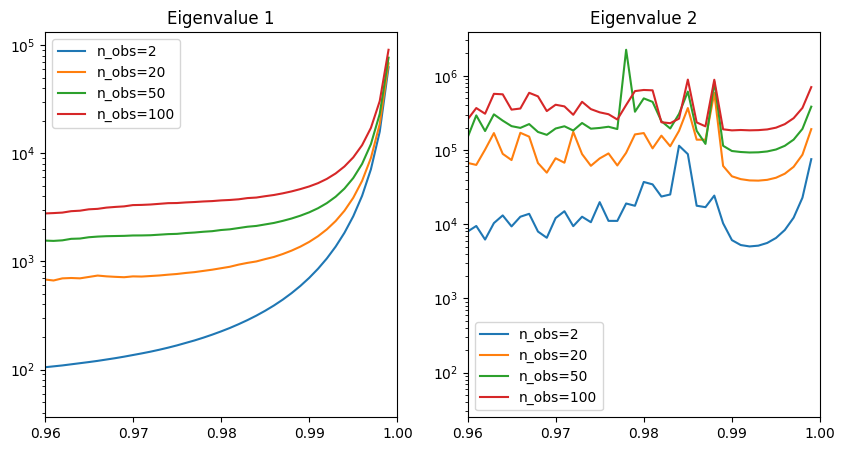

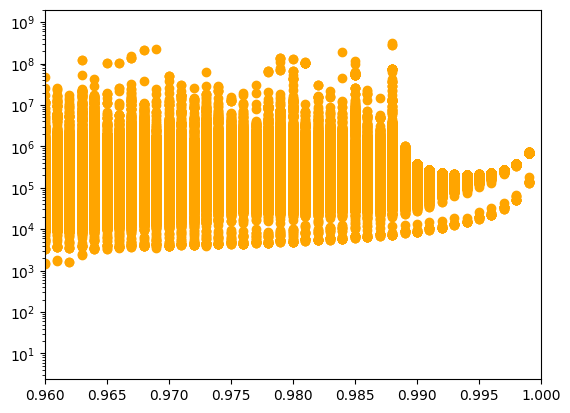

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for n_obs in [2, 20, 50, 100]:
    results = torch.load(f"../results/uniform/results_dict_n_obs_{n_obs}_lda_criteria.pkl")
    lda = results["lda"]

    lda_eigvals = torch.linalg.eigvals(lda).real

    t = torch.linspace(0, 1, results["all_theta_learned"].shape[0])

    ax[0].plot(t[:-1], lda_eigvals.mean(axis=1)[:,0], label=f"n_obs={n_obs}")
    ax[0].legend()
    ax[0].set_title("Eigenvalue 1")
    ax[0].set_yscale('log')
    ax[0].set_xlim(.96, 1)
    ax[1].plot(t[:-1],lda_eigvals.mean(axis=1)[:,1], label=f"n_obs={n_obs}")
    ax[1].legend()
    ax[1].set_title("Eigenvalue 2")
    ax[1].set_yscale('log')
    ax[1].set_xlim(.96, 1)
plt.show()


plt.scatter(t[:-1][:, None].repeat(1, lda_eigvals.shape[1]), lda_eigvals.max(dim=-1).values, color='orange')
plt.yscale('log')
plt.xlim(.96, 1)
plt.show()